In [1]:
import torch.nn as nn
import tensorflow as tf
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import numpy as np
import torchshow as ts

/Users/boris/PycharmProjects/Programming/Yandex_liceum/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
train,test=datasets.CIFAR10(root='CIFAR10',download=True,train=True,transform=transform),datasets.CIFAR10(root='CIFAR10',download=True,train=False,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader,test_loader=DataLoader(dataset=train,shuffle=True,batch_size=32),DataLoader(dataset=test,shuffle=True,batch_size=32)

In [5]:
# take a view on our dataset
def show_dataset(dataset_,dataset_labels_):
    # to show labels in convenient format
    cifar_10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
    }
    figure = plt.figure(figsize=(6, 6))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = tf.random.uniform(shape=(1,), minval=0, maxval=len(dataset_), dtype=tf.int64).numpy()[0]
        # retrieve image name and it's labels
        # img, label = dataset_[sample_idx],cifar_10_labels[dataset_labels_[sample_idx]]
        img, label = dataset_[sample_idx],dataset_labels_[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

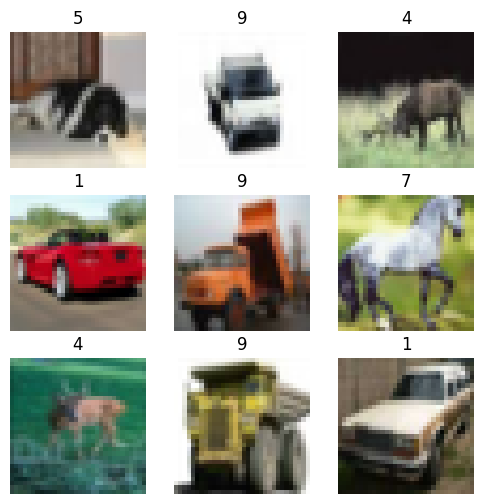

In [6]:
show_dataset(train.data,train.targets)

In [7]:
class Model(nn.Module):
    def __init__(self,latent_dim):
        super(Model, self).__init__()

        # Encoder
        # Свертка
        # (32 - 4) / 2 + 1 = 15 -> (15 - 3) + 2 + 1 -> 15 -> (15 - 3) + 1 => 13
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 35, kernel_size=4,stride=2),
            nn.ReLU(),
            nn.Conv2d(35, 70, kernel_size=3,padding = 1),
            nn.ReLU(),
            nn.Conv2d(70, 140, kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Два полносвязных слоя для MEAN и LOG_VARIANCE
        self.fc_mean_value = nn.Linear(140*13*13, latent_dim)
        self.fc_log_variance = nn.Linear(140*13*13, latent_dim)

        # Decoder
        # Развертка
        # Все действия были проделаны как в свертке в обратном порядке
        # ConvTranspose -> обратное Conv2d
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 140*13*13),
            nn.ReLU(),
            nn.Unflatten(1, (140,13,13)),
            nn.ConvTranspose2d(140, 70, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(70, 35, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.
            ConvTranspose2d(35, 3, kernel_size=4,stride=2),
            nn.Sigmoid()
        )
        
    # To print reconstructed images
    def process(self,x):
        return self(x)
    
    # encoding
    def encode(self, x):
        # Сертка изображения 
        x = self.encoder(x)
        # вычисление MEAN и LOG_VARIANCE для latent_space
        mean = self.fc_mean_value(x)
        logvariance = self.fc_log_variance(x)
        return mean, logvariance

    def compute_latent_space(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        # generates tensor of points with the same size as argument. 0 <= value <= 1.
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # развертка
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        # вычислим mean и logvar
        me, logvar = self.encode(x)
        # вычислим latent_space
        z = self.compute_latent_space(me, logvar)
        # декодим точку в скрытом пространстве
        x_reconstructed = self.decode(z)
        return x_reconstructed

In [8]:
from torchsummary import summary
latent_dimension,image_shape=300,(3,32,32)
model1=Model(latent_dim=latent_dimension)
summary(model1,input_size=image_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 35, 15, 15]           1,715
              ReLU-2           [-1, 35, 15, 15]               0
            Conv2d-3           [-1, 70, 15, 15]          22,120
              ReLU-4           [-1, 70, 15, 15]               0
            Conv2d-5          [-1, 140, 13, 13]          88,340
              ReLU-6          [-1, 140, 13, 13]               0
           Flatten-7                [-1, 23660]               0
            Linear-8                  [-1, 300]       7,098,300
            Linear-9                  [-1, 300]       7,098,300
           Linear-10                [-1, 23660]       7,121,660
             ReLU-11                [-1, 23660]               0
        Unflatten-12          [-1, 140, 13, 13]               0
  ConvTranspose2d-13           [-1, 70, 15, 15]          88,270
             ReLU-14           [-1, 70,

In [9]:
def training_process(loader, my_model, optimize, loss):
    # Turn on the training mode
    my_model.train()
    loss_val=0
    total_loss=0
    with torch.set_grad_enabled(True):
        for i, (images, labels) in tqdm(enumerate(loader), total=len(loader)):
            # forward pass
            reconstructed = my_model(images)
            # compute the loss
            loss_val = loss(reconstructed, images)
            # gradients are reset to zero
            optimize.zero_grad()
            # backward pass
            loss_val.backward()
            # update the weights
            optimize.step()
            total_loss+=loss_val.item()
    return float(total_loss/len(loader.dataset))

In [10]:
def evaluating_perfomance(loader_test,my_model,loss):
        my_model.eval()
        total_loss=0
        with torch.no_grad():
        # no updating weights
            for images,labels in loader_test:
                reconstructed = my_model.process(images)
                # compute loss on test dataset
                loss_val=loss(reconstructed,images)
                total_loss+=loss_val.item()
        # avg loss
        return float(total_loss/len(loader_test.dataset))

In [11]:
def plot_loss(loss,label,epochs):
    plt.title(label)
    plt.plot(loss)
    plt.grid()
    plt.xticks(np.arange(epochs))
def plot_losses(train_loss,testing_loss,epochs):
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    plot_loss(train_loss,label=f'Train loss: {train_loss[-1]}',epochs=epochs)
    plt.subplot(1,2,2)
    plot_loss(testing_loss,label=f'Test loss: {testing_loss[-1]}',epochs=epochs)
    plt.show()

In [12]:
def show_decoded_images(model_,test_data,samples):
    model_.eval()
    decoded_images=[]
    fig, axs = plt.subplots(2, samples, figsize=(15, 5))
    with torch.no_grad():
        random_image_indexes=list(np.random.randint(0,len(test_data),samples))
        original_images=[test_data[i][0] for i in random_image_indexes]
        for i in original_images:
            decoded_images.append(model_(i.unsqueeze(0)))
        print('Original Images:')
        for i in range(samples):
            img=np.transpose(original_images[i], (1, 2, 0))
            axs[0][i].imshow(img)
            axs[0][i].axis('off')
        print('Decoded Images:')
        for i in range(samples):
            if decoded_images[i].shape==torch.Size([1, 3, 32, 32]):
                img1 = np.transpose(decoded_images[i][0], (1, 2, 0))
            else:
                img1 = np.transpose(decoded_images[i], (1, 2, 0))
            axs[1][i].imshow(img1)
            axs[1][i].axis('off')

In [13]:
from IPython.display import clear_output
def run_epochs(model_type,epochs,loss_func):
    # to track loss and accuracy after each epoch
    train_loss,testing_loss=[],[]
    for epoch in range(1,epochs+1):
            print(f"Epoch number: {epoch}")
            print()
            print('Training..')
            loss_=training_process(loader=train_loader,my_model=model_type,optimize=optimizer,loss=loss_func)
            train_loss.append(loss_)
            print(f'Training_Loss: {train_loss[-1]}')
            print('Testing..')
            loss_test=evaluating_perfomance(loader_test=test_loader,my_model=model_type,loss=loss_func)
            testing_loss.append(loss_test)
            print(f'Testing_Loss: {testing_loss[-1]}')
            clear_output()
            show_decoded_images(model_type,test_data=test_loader.dataset,samples=8)
            plot_losses(train_loss,np.array(testing_loss),epochs)

In [14]:
# define hyperparameters
epochs=15
loss_func=nn.MSELoss(reduction='sum')
optimizer=torch.optim.Adam(model1.parameters(),lr=0.001)  

Original Images:
Decoded Images:


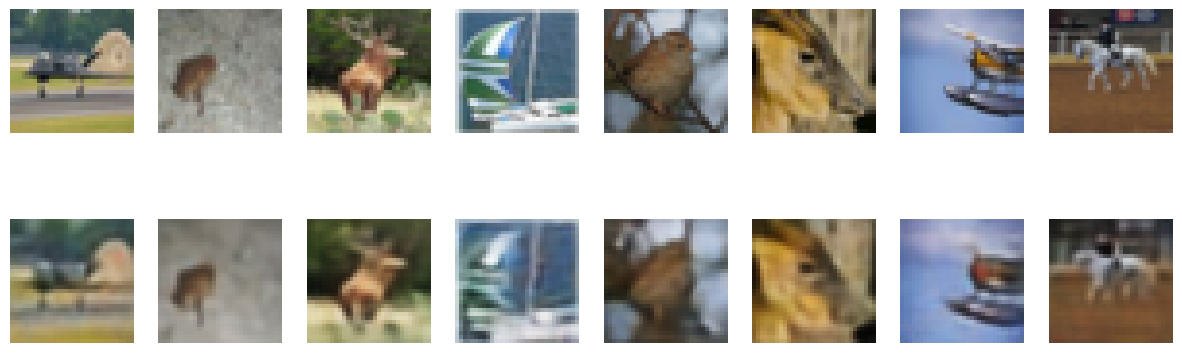

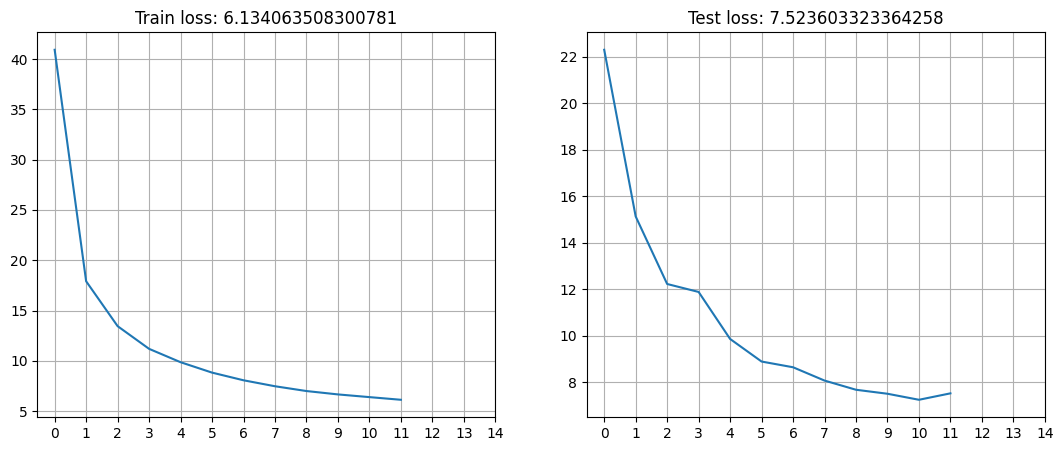

Epoch number: 13

Training..


 35%|███▌      | 552/1563 [01:07<02:03,  8.16it/s]


KeyboardInterrupt: 

In [15]:
run_epochs(model_type=model1,epochs=epochs,loss_func=loss_func)